## A2: Bias in data

#### Project Overview

The goal of this project is to explore the concept of 'bias' through data by analyzing Wikipedia articles on political figures from a variety of countries. The data will include a dataset of Wikipedia articles, a dataset of country populations, and the predicted article quality score data from a Wikipedia machine learning service.  

The project will quantify the number of Wikipedia pages devoted to politicians, the quality of those articles about politicians, and consider how those measurements vary between countries.  

The analysis will include a series of visualizations that show:  
  1. The countries with the greatest and least coverage of politicians on Wikipedia compared to their population.  
  2. The countries with the highest and lowest proportion of high quality articles about politicians.  
 

In [ ]:
"""
The code in this cell is optional, you do not need to run this cell
    in order to run subsequent cells.
To run a cell, position the cursor inside the cell, so the cell border
    turns green, and simultaneously press the keys: control and return (or enter).
"""

# This code displays all results created within a jupyter notebook cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# This code displays Matplotlib objects inline.
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

## Step 1. Getting the Data

We will be combining three sources of data:  
 - the Wikipedia dataset,
 - the population dataset, and
 - the article quality prediction dataset.

### Wikipedia Dataset
The Wikipedia dataset can be found on Figshare. The article data was extracted using the Wikimedia API and saved as a CSV file named page_data.csv. A copy of the `page_data.csv` file is available in the `data-512-a2` repository.   
  
The columns in the page_data.csv file are:
 1. country - this is the country name, extracted from the category name
 2. page - this is the Wikipedia page title
 3. last_edit - this is the edit ID of the last edit to the page, also called the revision_id

In [1]:
"""
The code in this cell reads in the Wikipedia article data from the
file page_data.csv with this data:
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 3 columns):
country      47997 non-null object
page         47997 non-null object
last_edit    47997 non-null int64
"""

import csv
import pandas as pd

page_data = pd.read_csv("page_data.csv") # 47997 entries
page_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 3 columns):
country      47997 non-null object
page         47997 non-null object
last_edit    47997 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


### Population Dataset
The population data is on the Population Research Bureau website, download the CSV file. In this notebook, the population data CSV file is named, `Population Mid-2015.csv`.

In [2]:
"""
The code in this cell reads in the country population data from
the file Population Mid-2015.csv.
When you just read Population Mid-2015.csv, the title becomes
a single column, to set the second row as the header, header=1.
"""

pop_data = pd.read_csv("Population Mid-2015.csv", skiprows=0,
                       header=1, sep=",", thousands=",")
pop_data.head()

,Location,Location Type,TimeFrame,Data Type,Data,Footnotes
0,Afghanistan,Country,Mid-2015,Number,32247000,NaN
1,Albania,Country,Mid-2015,Number,2892000,NaN
2,Algeria,Country,Mid-2015,Number,39948000,NaN
3,Andorra,Country,Mid-2015,Number,78000,NaN
4,Angola,Country,Mid-2015,Number,25000000,NaN


In [3]:
"""
    The code in this cell drops unneeded columns and renames columns.
"""

# Only drop unneeded columns if in DataFrame
if len(pop_data.columns) > 2:
    pop_data.drop(["Location Type", "TimeFrame",
                   "Data Type", "Footnotes"], axis=1, inplace=True)
else:
    pass

# Rename columns to standardize names for future merging
pop_data.rename(columns={"Location" : "country",
                         "Data" : "population"}, inplace=True)
pop_data.describe()

,population
count,2.100000e+02
mean,3.493092e+07
std,1.356373e+08
min,1.086000e+04
25%,1.249234e+06
50%,6.961524e+06
75%,2.367125e+07
max,1.371920e+09


### Article Quality Prediction Dataset

To get the predicted quality scores for each article in the Wikipedia dataset, we are using a Wikimedia API endpoint for a machine learning system called __ORES__ ("Objective Revision Evaluation Service").  

ORES estimates the quality of an article (at a particular point in time), and assigns a series of probabilities that the article is in one of 6 quality categories. The options are, from best to worst:  
  1.	FA - Featured article
  2.	GA - Good article
  3.	B - B-class article
  4.	C - C-class article
  5.	Start - Start-class article
  6.	Stub - Stub-class article  

For context, these quality classes are a sub-set of quality assessment categories developed by Wikipedia editors. For this assignment, you only need to know that these categories exist, and that ORES will assign one of these 6 categories to any article you send it.  

The ORES API is configured similarly to the pageviews API we used last assignment; documentation can be found [here](https://www.mediawiki.org/wiki/ORES) and the web API is [here](https://ores.wikimedia.org/v3/).  

It expects a revision ID, which is the third column in the Wikipedia dataset, and a model, which is "wp10". The sample iPython notebook for this assignment provides an example of a correctly-structured API query that you can use to understand how to gather your data, and also to examine the query output.  

In order to get article predictions for each article in the Wikipedia dataset, you will need to read page_data.csv into Python (or R), and then read through the dataset line by line, using the value of the last_edit column in the API query. If working in Python, the CSV module will help with this.  

When you query the API, you will notice that ORES returns a prediction value that contains the name of one category, as well as probability values for each of the 6 quality categories. But, you __only need to capture and use the value for prediction__.


In [4]:
import requests
import json
import time

try:
    """
        This is a shortcut, reading the saved data from a CSV file
        instead of calling the API to get article_quality prediction
        data since getting 47,997 API responses took about 4.27 hours.
    """
    page_data = pd.read_csv("page_quality_data.csv")
    page_data.drop(["Unnamed: 0"], axis=1, inplace=True)
    
except: 
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
    # headers = {'User-Agent' : 'https://github.com/orbitse', 'From' : 'orbite@uw.edu'}

    revision_id = []
    article_quality = []
    start = time.time()

    for line in page_data["last_edit"]:
        params = {"project" : "enwiki",
                  "model" : "wp10",
                  "revid" : str(line)
                  }

        api_call = requests.get(endpoint.format(**params))
        response = api_call.json()
        revision_id.append(line)
        article_quality.append(response["enwiki"]["scores"][str(line)]["wp10"]["score"]["prediction"])
        #print(json.dumps(response, indent=4, sort_keys=True))

    end = time.time() - start 
    print("Time:", str(end/60), "min") 
    # getting 47,997 responses took 256.3 min or 4.27 hours
    
    # append the predicted article quality column to the page_data DataFrame
    page_data["article_quality"] = article_quality
    page_data.to_csv("page_quality_data.csv")


In [5]:
# The first 10 rows in the page_data DataFrame
page_data.head(10)

,country,page,last_edit,article_quality
0,Abkhazia,Zurab Achba,802551672,C
1,Abkhazia,Garri Aiba,774499188,Stub
2,Abkhazia,Zaur Avidzba,803841397,C
3,Abkhazia,Raul Eshba,789818648,Start
4,Abkhazia,Guram Gabiskiria,785284614,Start
5,Abkhazia,Zakan Jugelia,798644673,Stub
6,Abkhazia,Zhiuli Shartava,728644481,Stub
7,Abkhazia,Yuri Voronov,788591677,Start
8,Abkhazia,Zaur Ardzinba,758713659,C
9,Abkhazia,Gennadi Berulava,802860970,Start


## 2. Combining the datasets

After retrieving and including the ORES data for each article, you'll merge the wikipedia data and population data together. Both have fields containing country names for just that purpose.  
After merging the data, you'll invariably run into entries which cannot be merged. Either the population dataset does not have an entry for the equivalent Wikipedia country, or vice versa. You will need to __remove the rows that do not have matching data__.  

Consolidate the remaining data into a single CSV file with these columns:  
  > country  
  > article_name   
  > revision_id  
  > article_quality  
  > population   
  
Note: revision_id here is the same thing as last_edit, which you used to get scores from the ORES API.


In [6]:
try:
    # Rename page_data columns
    page_data.rename(columns={"page" : "article_name",
                              "last_edit" : "revision_id"}, inplace=True)
except:
    pass

# Combine DataFrames on country names and remove any rows with empty values
combine_df = page_data.merge(pop_data,
                             how='outer', on=["country"]).dropna(axis=0,
                                                                 how='any').reset_index()
# Remove the old index which is now a column named index
# because I reset the index
combine_df.drop(["index"], axis=1, inplace=True)

# Change revision_id & population values from float to int
combine_df[["revision_id",
            "population"]] = combine_df[["revision_id",
                                         "population"]].astype(int)
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46348 entries, 0 to 46347
Data columns (total 5 columns):
country            46348 non-null object
article_name       46348 non-null object
revision_id        46348 non-null int64
article_quality    46348 non-null object
population         46348 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [7]:
combine_df.head()

,country,article_name,revision_id,article_quality,population
0,Afghanistan,Laghman Province,778690357,Start,32247000
1,Afghanistan,Roqia Abubakr,779839643,Stub,32247000
2,Afghanistan,Sitara Achakzai,803055503,GA,32247000
3,Afghanistan,Khadija Ahrari,805920528,GA,32247000
4,Afghanistan,Rahila Bibi Kobra Alamshahi,717743144,Stub,32247000


## 3. Analysis

Your analysis will consist of calculating the proportion (as a percentage) of articles-per-population and high-quality articles for each country. By "high quality" articles, in this case we mean the number of articles about politicians in a given country that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.
Examples:  
 - if a country has a population of 10,000 people, and you found 10 articles about politicians from that country, then the percentage of articles-per-population would be .1%. 
 - if a country has 10 articles about politicians, and 2 of them are FA or GA class articles, then the percentage of high-quality articles would be 20%.  
 

In [8]:
articles_per_country = combine_df[["country",
                                   "article_name"]].groupby("country").count().astype(int)

df_test = combine_df[["country",
                      "article_name"]].groupby("country").count().reset_index()

df_article_pop = df_test.merge(pop_data, on=["country"])

df_article_pop.rename(columns={"article_name" : "total_articles"},
                      inplace=True)

art_per_pop = df_article_pop["total_articles"].div(df_article_pop["population"],
                                                   axis='index')

df_article_pop["percent_articles_per_person"] = art_per_pop*100

prop_df = df_article_pop.sort_values(["percent_articles_per_person"],
                                      axis=0,
                                      ascending=False,
                                      inplace=False,
                                      kind='quicksort')
prop_df.head(10)

,country,total_articles,population,percent_articles_per_person
171,Tuvalu,55,11800,0.466102
119,Nauru,49,10860,0.451197
140,San Marino,87,33000,0.263636
112,Monaco,43,38088,0.112896
96,Liechtenstein,29,37570,0.077189
106,Marshall Islands,37,55000,0.067273
71,Iceland,206,330828,0.062268
166,Tonga,63,103300,0.060987
3,Andorra,34,78000,0.043590
53,Federated States of Micronesia,38,103000,0.036893


In [9]:
# number of GA and FA-quality articles as a proportion of all articles from country
fa_ga = combine_df[(combine_df["article_quality"]=="FA") | (combine_df["article_quality"]=="GA")]

total_fa_ga = fa_ga[["country",
                     "article_quality"]].groupby("country",
                                                 as_index=False).count()

total_articles = combine_df[["country",
                             "article_quality"]].groupby("country",
                                                         as_index=False).count()

art_type_df = total_fa_ga.merge(total_articles, on="country")

art_type_df.rename(columns={"article_quality_x" : "total_FA_GA",
                            "article_quality_y" : "total_pages"},
                   inplace=True)

art_type_df["percent_FA_GA"] = art_type_df["total_FA_GA"]/art_type_df["total_pages"].astype(float)*100

sort_prop_type_df = art_type_df.sort_values(["percent_FA_GA"],
                                            axis=0,
                                            ascending=False,
                                            inplace=False,
                                            kind='quicksort')
sort_prop_type_df.head(10)

,country,total_FA_GA,total_pages,percent_FA_GA
8,Azerbaijan,1,183,0.546448
93,Nepal,2,376,0.531915
135,Uganda,1,191,0.523560
41,Fiji,1,199,0.502513
90,Morocco,1,208,0.480769
87,Moldova,2,426,0.469484
34,Czech Republic,1,258,0.387597
42,Finland,2,572,0.349650
105,Peru,1,357,0.280112
127,Switzerland,1,410,0.243902


In [ ]:
sort_prop_type_df.tail(10)

## 4. Visualization 

Produce four visualizations that show:  
 1.	10 highest-ranked countries in terms of number of politician articles as a proportion of country population  
 2.	10 lowest-ranked countries in terms of number of politician articles as a proportion of country population  
 3.	10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country  
 4.	10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country  
 
We recommend using bar charts to visualize your data.  

In order to complete the assignment correctly and receive full credit, your graphs need to be the right scale to view the data; all units, axes, and values should be clearly labeled; and the graph should possess a key and a title. You must also generate a .png or .jpeg formatted image of your final graphs.  

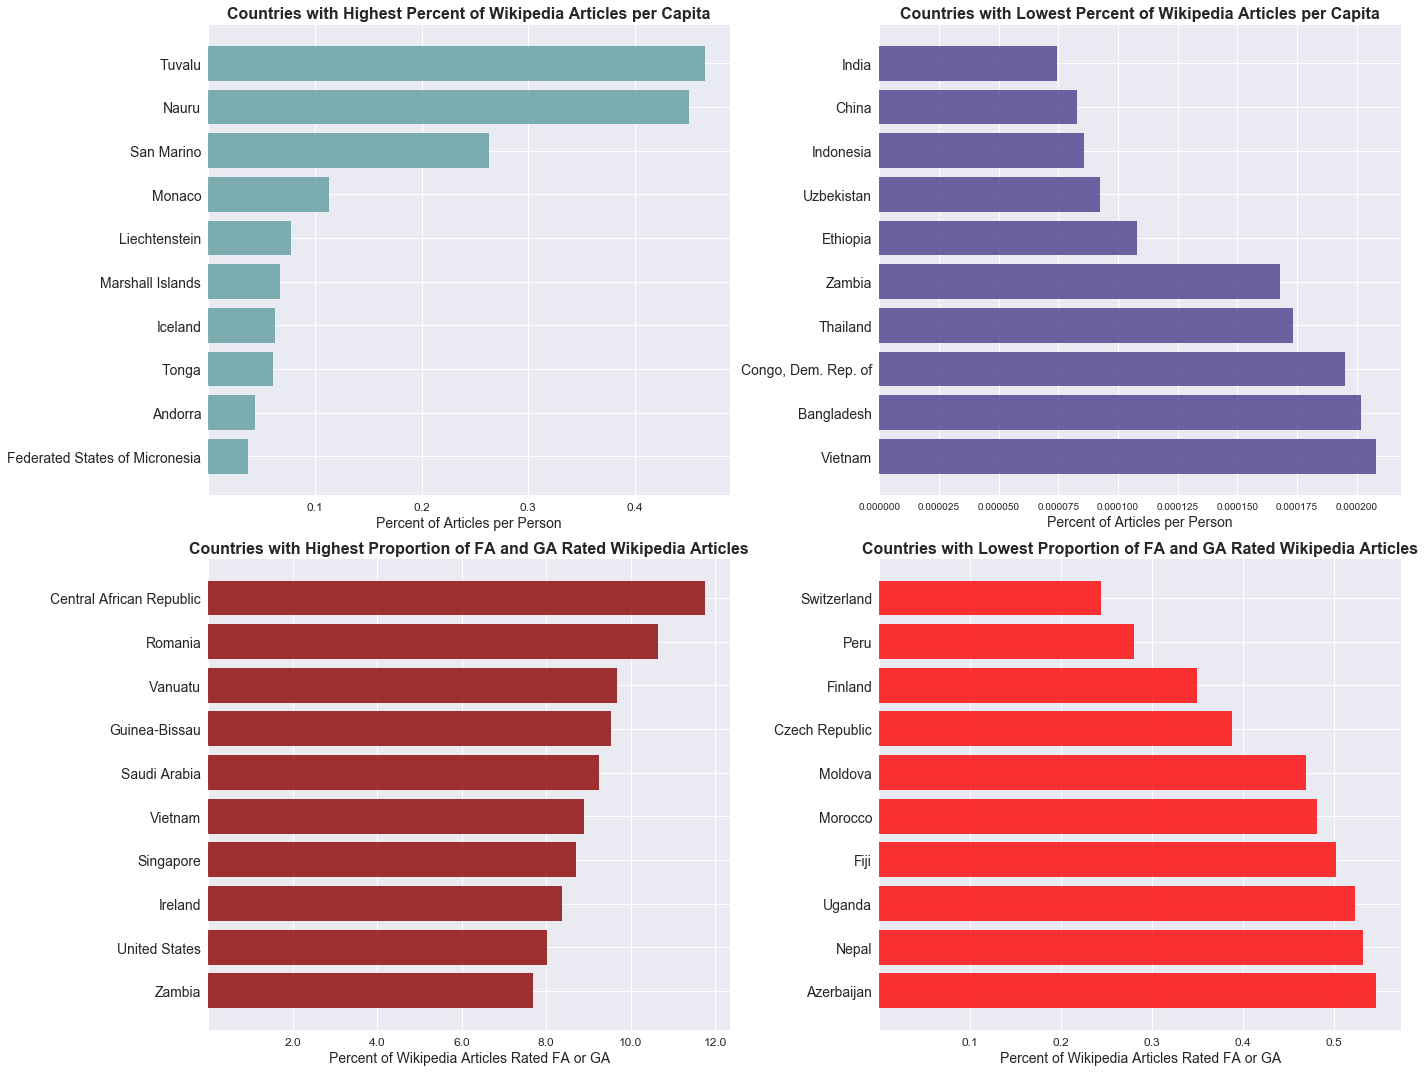

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from textwrap import wrap

# based on example from http://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html
#fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(10, 20))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

top_country = prop_df["country"].head(10)
y_pos = np.arange(len(top_country))
top_percent = prop_df["percent_articles_per_person"].head(10)

#ax.tick_params(axis="y", which='minor', bottom='off')
#ax.minorticks_on()

ax0.barh(y_pos, top_percent, align='center', color="cadetblue", alpha=0.8)
ax0.set_yticks(y_pos)
ax0.set_yticklabels(top_country, fontsize=14)
ax0.invert_yaxis()  # labels read top-to-bottom
ax0.set_xticklabels(labels=["", 0.1, 0.2, 0.3, 0.4], fontsize=12)
ax0.set_xlabel("Percent of Articles per Person", fontsize=14)
ax0.set_title("Countries with Highest Percent of Wikipedia Articles per Capita",
              fontsize=16, fontvariant="small-caps", fontweight="semibold")

bottom_country = prop_df["country"].tail(10)[::-1]
y_pos_2 = np.arange(len(bottom_country))
bottom_percent = prop_df["percent_articles_per_person"].tail(10)[::-1]

ax1.barh(y_pos_2, bottom_percent, align='center',
         color="darkslateblue", alpha=0.8)
ax1.set_yticks(y_pos_2)
ax1.set_yticklabels(bottom_country, fontsize=14)
ax1.invert_yaxis()
ax1.set_xlabel("Percent of Articles per Person",
               fontsize=14, fontstretch="semi-condensed")
ax1.set_title("Countries with Lowest Percent of Wikipedia Articles per Capita",
              fontsize=16, fontweight="semibold")

top_FA_GA_country = sort_prop_type_df["country"].head(10)
y_pos_3 = np.arange(len(top_good_country))
top_FA_GA_prop = sort_prop_type_df["percent_FA_GA"].head(10)

ax2.barh(y_pos_3, top_FA_GA_prop, align='center',
         color="darkred", alpha=0.8)
ax2.set_yticks(y_pos_3)
ax2.set_yticklabels(top_FA_GA_country, fontsize=14)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xticklabels(labels=["", 2.0, 4.0, 6.0, 8.0, 10.0, 12.0],
                    fontsize=12)
ax2.set_xlabel("Percent of Wikipedia Articles Rated FA or GA",
               fontsize=14, fontstretch="semi-condensed")
ax2.set_title("Countries with Highest Proportion of FA and GA Rated Wikipedia Articles",
              fontsize=16, fontweight="semibold")

bottom_FA_GA_country = sort_prop_type_df["country"].tail(10)[::-1]
y_pos_4 = np.arange(len(bottom_FA_GA_country))
bottom_FA_GA_prop = sort_prop_type_df["percent_FA_GA"].tail(10)[::-1]

ax3.barh(y_pos_4, bottom_FA_GA_prop, align='center',
         color="red", alpha=0.8)
ax3.set_yticks(y_pos_4)
ax3.set_yticklabels(bottom_FA_GA_country, fontsize=14)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_xticklabels(labels=["", 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=12)
ax3.set_xlabel("Percent of Wikipedia Articles Rated FA or GA",
               fontsize=14, fontstretch="semi-condensed")
ax3.set_title("Countries with Lowest Proportion of FA and GA Rated Wikipedia Articles",
              fontsize=16, fontweight="semibold",
              fontstretch="semi-condensed")

plt.tight_layout()

plt.show()

# Save plot to file
fig.savefig("WikipediaBiasDataPlot.png")

## Writeup

You are also expected to write a short reflection on the project, that describes how this assignment helps you understand the causes and consequences of bias on Wikipedia.  

Write a few paragraphs, either in the README or in the notebook, reflecting on what you have learned, what you found, what (if anything) surprised you about your findings, and/or what theories you have about why any biases might exist (if you find they exist).  

You can also include any questions this assignment raised for you about bias, Wikipedia, or machine learning.  

### Submission instructions
 1.	Complete your Notebook and datasets in Jupyter Hub.  
 2.	Create the data-512-a2 repository on GitHub w/ your code and data.  
 3.	Complete and add your README and LICENSE file.  
 4.	Submit the link to your GitHub repo to: https://canvas.uw.edu/courses/1174178/assignments/3876068
 
### Required deliverables
A directory in your GitHub repository called data-512-a2 that contains the following files:  
 1.	1 final data file in CSV format that follows the formatting conventions.  
 2.	1 Jupyter notebook named hcds-a2-bias that contains all code as well as information necessary to understand each programming step, as well as your writeup (if you have not included it in the README).  
 3.	1 README file in .txt or .md format that contains information to reproduce the analysis, including data descriptions, attributions and provenance information, and descriptions of all relevant resources and documentation (inside and outside the repo) and hyperlinks to those resources, and your writeup (if you have not included it in the notebook).  
 4.	1 LICENSE file that contains an MIT LICENSE for your code.  
 5.	1 .png or .jpeg image of your visualization.
